In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertTokenizer, BertModel
# from datasets import load_dataset
from sklearn.model_selection import train_test_split
import unicodedata as ucd


In [2]:
torch.cuda.is_available()

True

In [56]:
mapping = {
    "玄幻": 0,
    "奇幻": 1,
    "武侠": 2,
    "仙侠": 3,
    "都市": 4,
    "历史": 5,
    "游戏": 6,
    "科幻": 7,
    "奇闻异事": 8,
    "古代言情": 9,
    "现代言情": 10,
    "幻想言情": 11,
}
mapping_rec = {val: key for key, val in mapping.items()}
num_class = 12

In [21]:
class CustomDataset(Dataset):
    def __init__(self, excel_file):
        self.dataset = pd.read_excel(excel_file).values.tolist()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx][2].strip()
        text = ucd.normalize('NFKC', text).replace(" ", "")
        text = text.replace("\n", "").replace("……", "").replace("......", "")
        label = mapping[self.dataset[idx][1]]

        return text, label


In [22]:
train_dataset = CustomDataset('./data/full/train.xlsx')
val_dataset = CustomDataset("./data/full/val.xlsx")
print(len(train_dataset))
train_dataset[0]

20646


('水浒元世界!异世穿越!北宋末年!杜康紧缺!酒也能分等级?打斗场景竟能作为合成材料?我左手一坛N级蓝桥风月美酒,俘获一只小老鼠白胜;右手托着一坛R级十字坡浑色精酿,扈三娘投怀送抱,看得宋江咬牙切齿!一坛又一坛,送我上梁山!拉帮结派全不会啊,说学逗唱忽悠最在行!',
 5)

In [23]:
maxLen = 0
for text, label in train_dataset:
    if len(text) > maxLen:
        maxLen = len(text)
maxLen

508

In [24]:
token = BertTokenizer.from_pretrained('../bert-base-chinese')  # 要跟预训练模型相匹配
def collate_fn(data):
    sents = [i[0] for i in data]
    labels = [i[1] for i in data]

    #编码
    data = token.batch_encode_plus(batch_text_or_text_pairs=sents,
                                   truncation=True,   # 当句子长度大于max_length时，截断
                                   padding='max_length',   # 一律补0到max_length长度
                                   max_length=500,
                                   return_tensors='pt',   # 返回pytorch类型的tensor
                                   return_length=True)   # 返回length，标识长度

    input_ids = data['input_ids']    # input_ids:编码之后的数字
    attention_mask = data['attention_mask']     # attention_mask:补零的位置是0,其他位置是1
    token_type_ids = data['token_type_ids']   # 第一个句子和特殊符号的位置是0，第二个句子的位置是1(包括第二个句子后的[SEP])
    labels = torch.LongTensor(labels)

    return input_ids, attention_mask, token_type_ids, labels

In [25]:
sample = [train_dataset[0]]
print(sample)
input_ids, attention_mask, token_type_ids, labels = collate_fn(sample)
input_ids.shape, attention_mask.shape, token_type_ids.shape, labels 

[('水浒元世界!异世穿越!北宋末年!杜康紧缺!酒也能分等级?打斗场景竟能作为合成材料?我左手一坛N级蓝桥风月美酒,俘获一只小老鼠白胜;右手托着一坛R级十字坡浑色精酿,扈三娘投怀送抱,看得宋江咬牙切齿!一坛又一坛,送我上梁山!拉帮结派全不会啊,说学逗唱忽悠最在行!', 5)]


(torch.Size([1, 500]), torch.Size([1, 500]), torch.Size([1, 500]), tensor([5]))

In [26]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=16,
                                        collate_fn=collate_fn,
                                        shuffle=True,
                                        # pin_memory=True,
                                        # num_workers=4,
                                        drop_last=False)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                        batch_size=16,
                                        collate_fn=collate_fn,
                                        shuffle=True,
                                        # pin_memory=True,
                                        # num_workers=4,
                                        drop_last=False)

In [27]:
# 查看数据样例
for i, (input_ids, attention_mask, token_type_ids,
        labels) in enumerate(train_loader):
    break

print(len(train_loader))  
input_ids.shape, attention_mask.shape, token_type_ids.shape, labels 

1291


(torch.Size([16, 500]),
 torch.Size([16, 500]),
 torch.Size([16, 500]),
 tensor([ 3, 10, 10,  1,  4,  2, 11,  4,  0,  0,  0,  7,  4,  4,  2, 10]))

In [28]:
#加载预训练模型
pretrained = BertModel.from_pretrained('../bert-base-chinese').cuda()
#不训练,不需要计算梯度
for param in pretrained.parameters():
    param.requires_grad_(False)

In [29]:
#模型试算
out = pretrained(input_ids=input_ids.cuda(),
           attention_mask=attention_mask.cuda(),
           token_type_ids=token_type_ids.cuda())

out.last_hidden_state.shape

torch.Size([16, 500, 768])

In [30]:
#定义下游任务模型
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(768, num_class)  # 单层网络模型，只包括了一个fc的神经网络

    def forward(self, input_ids, attention_mask, token_type_ids):
        with torch.no_grad():
            out = pretrained(input_ids=input_ids,   # 先拿预训练模型来做一个计算，抽取数据当中的特征
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids)

        # 把抽取出来的特征放到全连接网络中运算，且特征的结果只需要第0个词的特征(跟bert模型的设计方式有关。对句子的情感分类，只需要拿特征中的第0个词来进行分类就可以了)
        out = self.fc(out.last_hidden_state[:, 0])   # torch.Size([16, 768])
        
        # # 将softmax函数应用于一个n维输入张量，对其进行缩放，使n维输出张量的元素位于[0,1]范围内，总和为1
        # out = out.softmax(dim=1)  

        return out

model = Model().cuda()

In [31]:
model(input_ids=input_ids.cuda(),
      attention_mask=attention_mask.cuda(),
      token_type_ids=token_type_ids.cuda()).shape

torch.Size([16, 12])

In [83]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss().cuda()

In [32]:
#训练下游任务模型

model.train()
total_iter = len(train_loader)
losses = []

for i, (input_ids, attention_mask, token_type_ids,
        labels) in enumerate(train_loader):
    labels = labels.cuda()
    out = model(input_ids=input_ids.cuda(),
                attention_mask=attention_mask.cuda(),
                token_type_ids=token_type_ids.cuda())

    loss = criterion(out, labels)  # 输出跟真实的labels计算loss
    loss.backward()   # 调用反向传播得到每个要更新参数的梯度
    optimizer.step()  # 每个参数根据上一步得到的梯度进行优化
    optimizer.zero_grad()  # 把上一步训练的每个参数的梯度清零
    losses.append(loss.item())

    if i % 10 == 0:
        out = out.argmax(dim=1)
        accuracy = (out == labels).sum().item() / len(labels)
        print(f"Iter {i+1}/{total_iter}: Loss {loss.item() :.4f} Accuracy {accuracy :.4f}")

Iter 1/1291: Loss 2.4600 Accuracy 0.0625
Iter 11/1291: Loss 2.5470 Accuracy 0.2500
Iter 21/1291: Loss 2.3643 Accuracy 0.1250
Iter 31/1291: Loss 2.0205 Accuracy 0.1250
Iter 41/1291: Loss 2.4757 Accuracy 0.1875
Iter 51/1291: Loss 1.6559 Accuracy 0.5625
Iter 61/1291: Loss 1.7421 Accuracy 0.5000
Iter 71/1291: Loss 1.8872 Accuracy 0.4375
Iter 81/1291: Loss 2.0320 Accuracy 0.2500
Iter 91/1291: Loss 2.1840 Accuracy 0.3125
Iter 101/1291: Loss 1.7409 Accuracy 0.5625
Iter 111/1291: Loss 2.0610 Accuracy 0.3125
Iter 121/1291: Loss 1.8968 Accuracy 0.3125
Iter 131/1291: Loss 2.1123 Accuracy 0.3750
Iter 141/1291: Loss 1.4658 Accuracy 0.6250
Iter 151/1291: Loss 1.9266 Accuracy 0.4375
Iter 161/1291: Loss 1.6478 Accuracy 0.5625
Iter 171/1291: Loss 1.9159 Accuracy 0.3750
Iter 181/1291: Loss 1.6427 Accuracy 0.3750
Iter 191/1291: Loss 1.8816 Accuracy 0.2500
Iter 201/1291: Loss 2.2981 Accuracy 0.2500
Iter 211/1291: Loss 2.1178 Accuracy 0.1875
Iter 221/1291: Loss 2.0251 Accuracy 0.3125
Iter 231/1291: Loss 1.

In [81]:
def output_fn(sents, model, mode='full'):
    data = token.batch_encode_plus(batch_text_or_text_pairs=sents,
                                   truncation=True,   # 当句子长度大于max_length时，截断
                                   padding='max_length',   # 一律补0到max_length长度
                                   max_length=500,
                                   return_tensors='pt',   # 返回pytorch类型的tensor
                                   return_length=True)   # 返回length，标识长度

    input_ids = data['input_ids']    # input_ids:编码之后的数字
    attention_mask = data['attention_mask']     # attention_mask:补零的位置是0,其他位置是1
    token_type_ids = data['token_type_ids']
    
    model = model.cuda()
    logit = model(input_ids=input_ids.cuda(),
        attention_mask=attention_mask.cuda(),
        token_type_ids=token_type_ids.cuda()).detach().cpu()
    scores = torch.softmax(logit, axis=-1)
    if mode == 'full':
        sorted_scores, idxs = torch.sort(scores, axis=-1, descending = True)
        sorted_scores = sorted_scores.tolist()
        idxs = idxs.tolist()
        # print(logit)
        out = [(mapping_rec[idx], score) for idx, score in zip(*idxs, *sorted_scores)]
    else:
        score, pred = torch.max(scores, axis=-1)
        score = score.item()
        pred = pred.item()
        pred = mapping_rec[pred]
        out = (pred, score)
    
    return out

In [82]:
demo = "如果天道无情，我便伐了这天！"
output_fn([demo], model)

[('仙侠', 0.41669586300849915),
 ('玄幻', 0.27042803168296814),
 ('古代言情', 0.09472974389791489),
 ('奇幻', 0.05857185646891594),
 ('幻想言情', 0.05615478381514549),
 ('历史', 0.03144925832748413),
 ('武侠', 0.026061752811074257),
 ('奇闻异事', 0.018999552354216576),
 ('都市', 0.012566288001835346),
 ('科幻', 0.00986560806632042),
 ('现代言情', 0.0023738027084618807),
 ('游戏', 0.0021035170648247004)]

In [84]:
def top_k_accuracy(output, target, k=1):
    with torch.no_grad():
        _, topk_indices = output.topk(k, dim=1, largest=True, sorted=True)
        topk_correct = topk_indices.eq(target.view(-1, 1).expand_as(topk_indices))
        topk_correct = topk_correct.float().sum()
        return topk_correct / target.size(0)


In [90]:
def val(model, loader):
    top_1 = []
    top_3 = []
    model.eval()
    for i, (input_ids, attention_mask, token_type_ids,
        labels) in enumerate(loader):
        # labels = labels.cuda()
        with torch.no_grad():
            out = model(input_ids=input_ids.cuda(),
                        attention_mask=attention_mask.cuda(),
                        token_type_ids=token_type_ids.cuda()).detach().cpu()
        top_1.append(top_k_accuracy(out, labels, k=1).item())
        top_3.append(top_k_accuracy(out, labels, k=3).item())
        
    return top_1, top_3
        

In [93]:
import numpy as np
top1, top3 = val(model, val_loader)
print(f"Val Top-1 Accuracy: {np.mean(top1)}   Val Top-3 Accuracy: {np.mean(top3)}")

Val Top-1 Accuracy: 0.5222222223693942   Val Top-3 Accuracy: 0.813966049456302


In [94]:
# 保存分类器权重
torch.save(model.fc.state_dict(), "./checkpoints/bert_fc_full.pth")

In [95]:
# 训练下游任务模型——第三轮
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss().cuda()

model.train()
losses = []
accuracies = []

for i, (input_ids, attention_mask, token_type_ids,
        labels) in enumerate(train_loader):
    labels = labels.cuda()
    out = model(input_ids=input_ids.cuda(),
                attention_mask=attention_mask.cuda(),
                token_type_ids=token_type_ids.cuda())

    loss = criterion(out, labels)  # 输出跟真实的labels计算loss
    loss.backward()   # 调用反向传播得到每个要更新参数的梯度
    optimizer.step()  # 每个参数根据上一步得到的梯度进行优化
    optimizer.zero_grad()  # 把上一步训练的每个参数的梯度清零
    losses.append(loss.item())

    if i % 10 == 0:
        out = out.argmax(dim=1)
        accuracy = (out == labels).sum().item() / len(labels)
        accuracies.append(accuracy)
        print(f"Iter {i+1}/{total_iter}: Loss {loss.item() :.4f} Accuracy {accuracy :.4f}")

Iter 1/1291: Loss 1.7484 Accuracy 0.3125
Iter 11/1291: Loss 1.1340 Accuracy 0.5625
Iter 21/1291: Loss 1.4454 Accuracy 0.5000
Iter 31/1291: Loss 1.7737 Accuracy 0.5000
Iter 41/1291: Loss 1.2550 Accuracy 0.5625
Iter 51/1291: Loss 1.2916 Accuracy 0.4375
Iter 61/1291: Loss 2.2298 Accuracy 0.3750
Iter 71/1291: Loss 1.8242 Accuracy 0.3125
Iter 81/1291: Loss 1.4764 Accuracy 0.6875
Iter 91/1291: Loss 1.2469 Accuracy 0.5625
Iter 101/1291: Loss 1.1477 Accuracy 0.6250
Iter 111/1291: Loss 1.2040 Accuracy 0.6250
Iter 121/1291: Loss 1.5547 Accuracy 0.5000
Iter 131/1291: Loss 1.5690 Accuracy 0.3750
Iter 141/1291: Loss 1.3712 Accuracy 0.5625
Iter 151/1291: Loss 1.5369 Accuracy 0.5625
Iter 161/1291: Loss 1.5237 Accuracy 0.5000
Iter 171/1291: Loss 1.7741 Accuracy 0.3750
Iter 181/1291: Loss 1.4387 Accuracy 0.5000
Iter 191/1291: Loss 1.4459 Accuracy 0.6250
Iter 201/1291: Loss 0.9083 Accuracy 0.6875
Iter 211/1291: Loss 0.9374 Accuracy 0.7500
Iter 221/1291: Loss 1.8117 Accuracy 0.5000
Iter 231/1291: Loss 1.

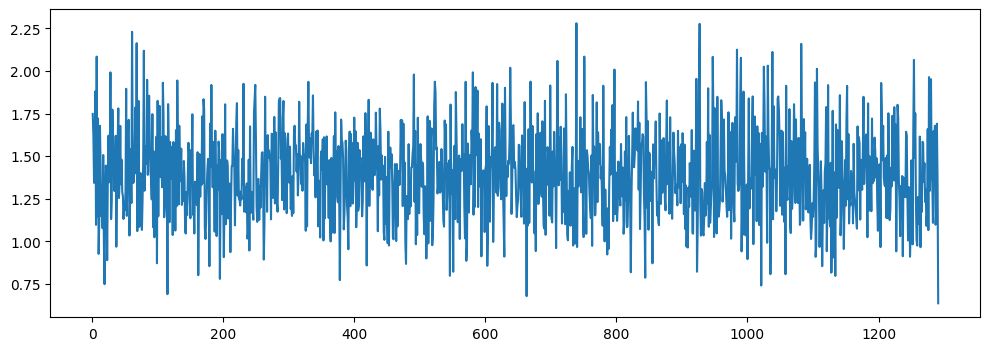

In [99]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 4))
t = list(range(1, total_iter+1))
plt.plot(t, losses)
plt.show()

In [100]:
top1, top3 = val(model, val_loader)
print(f"Val Top-1 Accuracy: {np.mean(top1)}   Val Top-3 Accuracy: {np.mean(top3)}")

Val Top-1 Accuracy: 0.5496913580982773   Val Top-3 Accuracy: 0.8306327160493827


In [101]:
torch.save(model.fc.state_dict(), "./checkpoints/bert_fc_full_epoch_2.pth")

In [102]:
demo = "如果天道无情，我便伐了这天！"
output_fn([demo], model)

[('玄幻', 0.38104167580604553),
 ('仙侠', 0.24040751159191132),
 ('古代言情', 0.11964794248342514),
 ('幻想言情', 0.07629632204771042),
 ('奇幻', 0.06448373943567276),
 ('历史', 0.03469283878803253),
 ('武侠', 0.02395523339509964),
 ('奇闻异事', 0.023588649928569794),
 ('都市', 0.020502159371972084),
 ('科幻', 0.010591985657811165),
 ('现代言情', 0.002651848364621401),
 ('游戏', 0.002140090335160494)]